<h1>Manifold learning based on quadratically regularised optimal transport</h1>
<p>Author: Gilles Mordant</p>

Oftentimes, data is high dimensional but lives on a lower dimensional manifold. 
For example, one could have a dataset with 100 variables but the data admits a structure and would only live on a (non-linear) 10 dimensional subspace. 
Images are extremely high dimensional but only a subset of all possible pixel-value combinations could be understood as proper pictures. 
As this subspace is unknown, one aims at recovering it, this is called manifold learning. 


To do so, the basic principle is to connect the observed points locally, thus forming patches and then glue the patches together to recover the low-dimensional structure hidden in the high dimensional one.

In this note, we show how one can use optimal transport with $L^2$ regularisation to construct adaptive "kernels" that respect the geometry, which constitute the basis for the patches defined above.

<h3> Self Optimal Transport with quadratic regularisation</h3>

Consider a set of points $\{x_i\}_{i=1}^n$ and construct a cost matrix $C:= (c(x_i, x_j))$. Usually, the function $c$ is the squared Euclidean distance. 

Then consider the problem 
$$
            \min_{\pi\in B_n}\ \langle \pi , C \rangle_F + \varepsilon \lVert \pi \rVert_F^2,
$$
where $B_n$ is the set of bistochastic matrices and $\varepsilon$ is a regularisation parameter that controls the locality of the kernel.

The solution of this problem $\pi^\star$ is such that 
$$
            \pi^\star_{i,j} = \frac{ \max\big(u_i + u_j - c(x_i, x_j), 0\big) }{\varepsilon},   
$$
for some optimal dual potential vector $u$. Owing to the positive part function at the numerator, one sees that the kernel will be local as the matrix $\pi$ will have many zero entries. 

<h3> On the form of the kernel and diffusion equations</h3>

In Mordant and Zhang (2022+), considering the squared Euclidean norm as cost function, it is shown that the first order approximation of the vector $u$ should be $u \sim \varepsilon^{2/(2+d)}$ where $d$ is teh dimension of the underlying manifold.
It then turns out that the optimal transport plan has the form  
$$
            \pi^\star_{i,j} \sim \frac{ \max\big( 2\varepsilon^{2/(2+d)} - \lVert x_i- x_j\rVert^2, 0\big) }{\varepsilon},   
$$
which is reminiscent of the Barenblatt--Prattle formula. The latter desribes how a Dirac mass is diffused when the diffusion follows the the porous medium (partial differential)) equation, i.e., 
$$
\frac{\partial u(t,x)}{\partial t} = \Delta (u(t,x)^2).
$$

<h3> Making the procedure robust to heteroskedastic noise in high dimension</h3>

It turns out that if one replaces $B_n$ by $B_n^\circ := \{\pi : \pi \geq0; \pi_{ii}=0,  \forall i\le n; \pi= \pi^\top; \pi 1_n = 1_n    \}$, the optimal transport plan 
$$
          \pi^* := {\arg \min}_{\pi\in B_n^\circ}\ \langle \pi , C \rangle_F + \varepsilon \lVert \pi \rVert_F^2
$$
becomes robust to heteroskedastic noise in high dimensions.
$B_n^\circ$ only differs through the fact that it is zero on the diagonal. Seeing $\pi^*$ as the adjacency matrix of a graph, it means that no-self loop is allowed.

If one assume a model with $n$ corrupted points
$$
\tilde x_i = x_i + \eta_i ,
$$
where $x_i \in \mathbb{R}^m$ and
 $\eta_i$ is centred noise such that $\|\mathbb{E}[\eta_i\eta_i^\top]\|_2 \le C_\eta m^{-1}, \forall i \le n$ and some constant $C_\eta$, the reason behind robustness to noise is seen from the fact that 
$$
\|\tilde x_i- \tilde x_j  \|^2= \| x_i-  x_j  \|^2 +  \| \eta_i\|^2 + \|\eta_j  \|^2 + O_p(m^{-1/2}) \qquad (i\neq j)
$$
if $\| x_i\|\le 1$. The, terms $\| \eta_i\|^2 + \|\eta_j  \|^2$ will then be absorbed by the dual potentials.


In [58]:
# Load principal libraries
import numpy as np
import os
import matplotlib.pyplot as plt
# compute distance matrix between points efficiently
import sklearn
from sklearn import manifold
from scipy.spatial.distance import cdist
import csv


We first construct a few functions.

In [59]:
def Phi(C,eps, a): 
    temp=  np.sum( (np.maximum(a + np.transpose(a)- C, 0 ))**2)*0.5 - eps*2*np.sum(a)
    return (temp)

def QuadOt(C, eps, Maxiter=500):
    nRow=C.shape[1]
    one=np.transpose(np.array([np.repeat(1, nRow),]))
    u=one
    delta=0.0001
    k=0.5
    tau=1e-5
    itNbr=1
    converged=1
    while(converged):
        if(itNbr>Maxiter):
            break
        P= u+np.transpose(u) - C
        Sigma= P>0
        Pi=np.maximum(P,0)/eps
        if ( np.amax(np.abs(np.sum(Pi, axis=0) - one)) <tau ):
            break
        A= Sigma+ np.diag(Sigma@one.reshape((nRow,)))+ delta*np.eye(nRow)
        b=-eps* (Pi - np.eye(nRow))@ one
        Delta=np.linalg.solve(A,b)
        d= eps*np.sum(Pi * (Delta+np.transpose(Delta))) - 2*eps *np.sum(Delta)
        t=1
        while( Phi(C,eps, (u+t*Delta))>= Phi(C,eps, u) + t*d*0.9 ):
            t*=k
            if(t< 1e-10):
                break
        u= u +t*Delta
        itNbr+=1
    return( np.maximum(u+np.transpose(u) - C,0)/eps  )

        
def sampleCoil(n):
    t=np.array(np.arange(0,2*np.pi, 2*np.pi/n))
    output= np.transpose(np.vstack((
        np.array(np.cos(t)*(0.5*np.cos(6*t)+1)), 
        np.array(np.sin(t)*(0.4*np.cos(6*t)+1)),
        np.array(    0.4*np.sin(6*t) ))))
    return(output)

    

We now generate equispaced points on a coil and plot both the distance matrix and the transport plan.

Text(0.5, 1.0, 'Optimal transport plan (with L2 regularisation)')

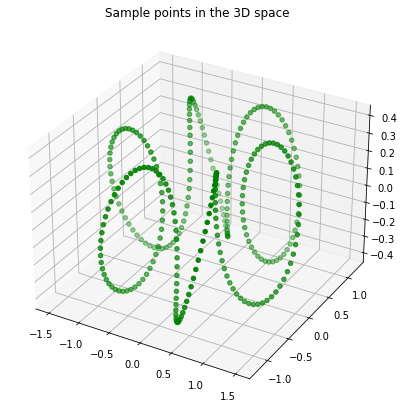

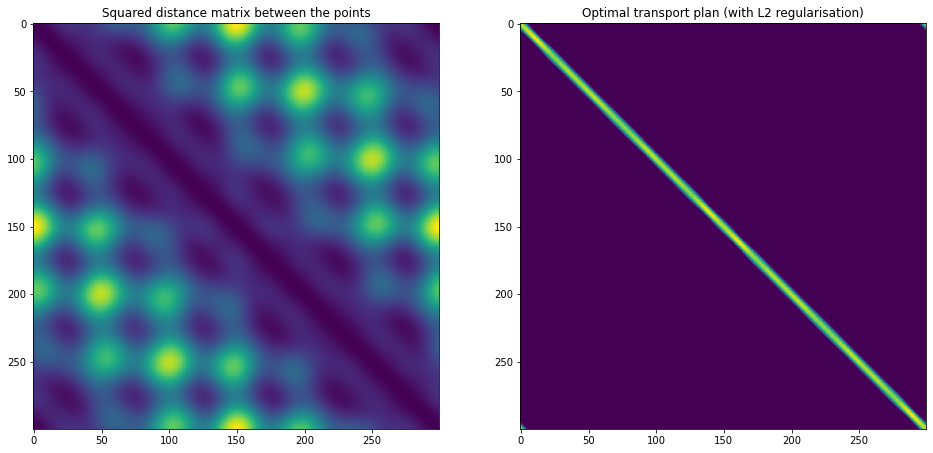

In [60]:
n=300
points=sampleCoil(n)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
plt.title("Sample points in the 3D space")
ax.scatter3D(points[:,0], points[:,1],points[:,2], color = "green")

C =  cdist(points, points, 'sqeuclidean')

plan=QuadOt(C, eps=0.7)

#-------------------------------------
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(C)
plt.title("Squared distance matrix between the points")
plt.subplot(1,2,2)
plt.imshow(plan)
plt.title("Optimal transport plan (with L2 regularisation)")


Once the transport plan has been computed, the latter can be seen as an adjacency matrix and used in a spectral embedding. 
On then plots the point cloud represented in its two first principal directions. 

Text(0.5, 1.0, 'Two principal dimensions of the coil')

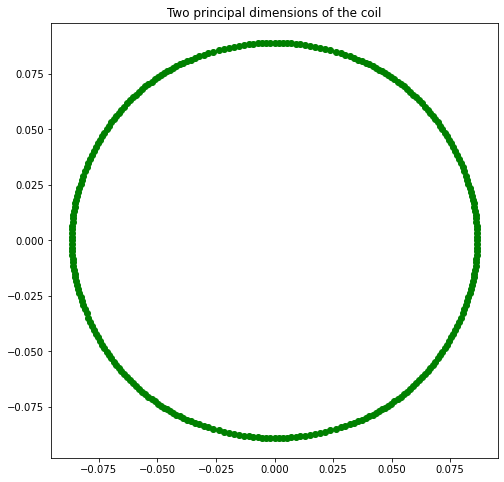

In [61]:
#Manifold learning part

mfld= sklearn.manifold.spectral_embedding(plan, n_components=2) 
plt.figure(figsize=(8,8))
plt.scatter(mfld[:,0],mfld[:,1], color = "green")
plt.title("Two principal dimensions of the coil")

Text(0.5, 1.0, 'Optimal transport plan (with L2 regularisation)')

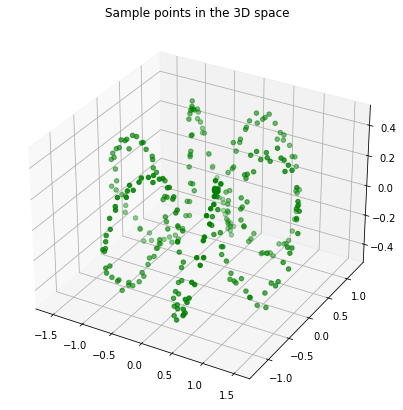

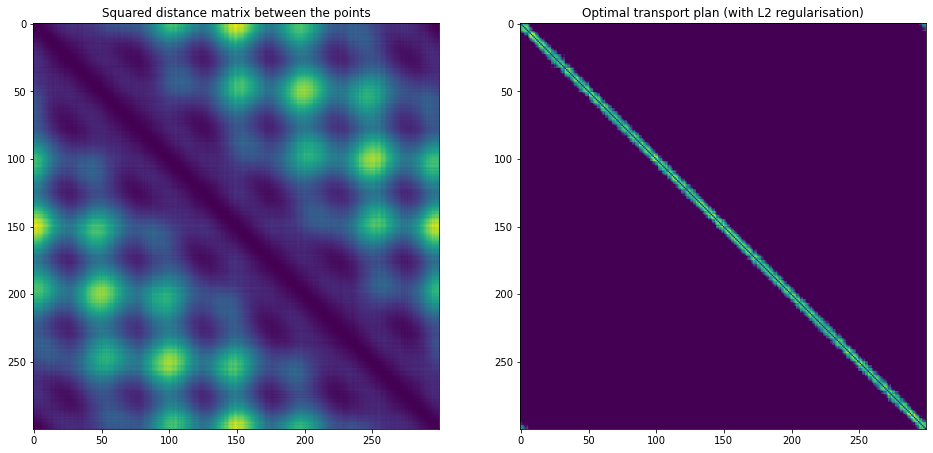

In [62]:
# Let us check with addition of noise in 3D

noise= np.random.normal(size= points.shape)
corruptPoints = points + noise*0.03 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
plt.title("Sample points in the 3D space")
ax.scatter3D(corruptPoints[:,0], corruptPoints[:,1],corruptPoints[:,2], color = "green")

C =  cdist(corruptPoints, corruptPoints, 'sqeuclidean')


#-------------------------------------
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(C)
plt.title("Squared distance matrix between the points")
CAlt = C
np.fill_diagonal(CAlt, 1000000)
plan=QuadOt(CAlt, eps=0.7)
plt.subplot(1,2,2)
plt.imshow(plan)
plt.title("Optimal transport plan (with L2 regularisation)")

Text(0.5, 1.0, 'Two principal dimensions of the coil')

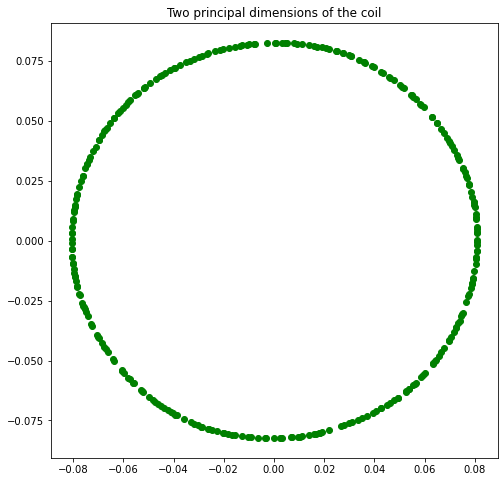

In [63]:
#Manifold learning part

mfld= sklearn.manifold.spectral_embedding(plan, n_components=2) 
plt.figure(figsize=(8,8))
plt.scatter(mfld[:,0],mfld[:,1], color = "green")
plt.title("Two principal dimensions of the coil")

We see that noise has an impact, as one could expect. The choice of epsilon is important as described in the paper. 

Text(0.5, 1.0, 'Two principal dimensions of the coil')

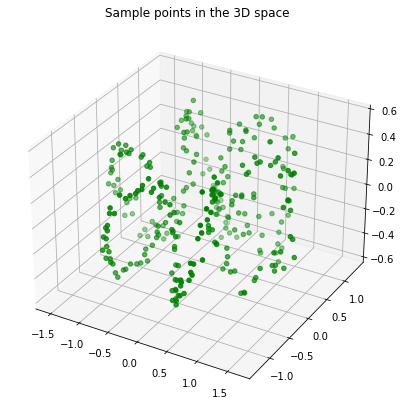

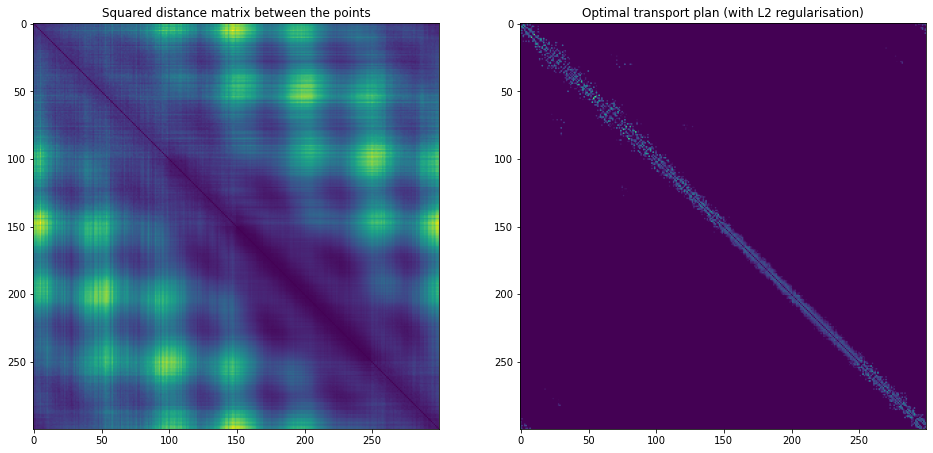

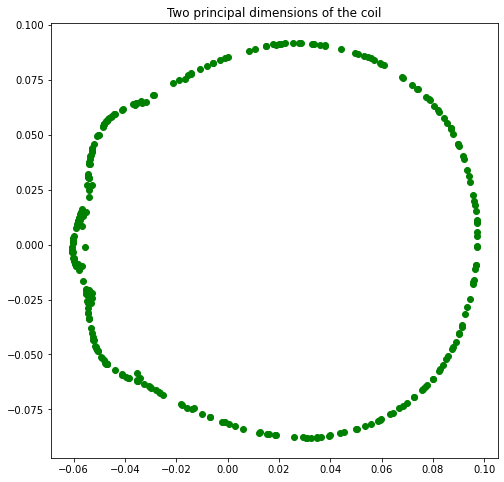

In [64]:
# Let us check with addition of noise in 3D
HDpoints= np.zeros((300,100))
HDpoints[:,0:3]=points
noise= np.random.normal(size= HDpoints.shape) *0.06
noise[1:100,:]= noise[1:100,:]*1.5
noise[150:250,:]= noise[150:250,:]/2
corruptPoints = HDpoints +noise
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
plt.title("Sample points in the 3D space")
ax.scatter3D(corruptPoints[:,0], corruptPoints[:,1],corruptPoints[:,2], color = "green")

C =  cdist(corruptPoints, corruptPoints, 'sqeuclidean')


#-------------------------------------
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(C)
plt.title("Squared distance matrix between the points")
CAlt = C
np.fill_diagonal(CAlt, 1000000)
plan=QuadOt(CAlt, eps=0.9)
plt.subplot(1,2,2)
plt.imshow(plan)
plt.title("Optimal transport plan (with L2 regularisation)")

#Manifold learning part

mfld= sklearn.manifold.spectral_embedding(plan, n_components=2) 
plt.figure(figsize=(8,8))
plt.scatter(mfld[:,0],mfld[:,1], color = "green")
plt.title("Two principal dimensions of the coil")

The impact of heteroskedastoic noise is mitigated by the stability properties described in the paper. 
However, as the structure gets blurry, one can expect that it gets more difficult to recover the underlying shape.